<a href="https://colab.research.google.com/github/tthakur2015/World-Bank-Exploratory-Data-Analysis---Education-Data/blob/main/Individual_Project_Notebook_Tejas_Thakur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import random

import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates

%matplotlib inline

## Import and Preliminary Analysis

In [ ]:
directory_path = "/content/drive/MyDrive/Almabetter/Capstone Project - EDA/data/"

shapefile_geopandas = "/content/drive/MyDrive/Almabetter/Capstone Project - EDA/data/110m_cultural/ne_110m_admin_0_countries.shp"

# Reading csv data into dataframes

main_df = pd.read_csv(directory_path+"EdStatsData.csv")
main_df = main_df.drop(columns = ['2015', '2016','2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100','Unnamed: 69'])

country_code_df =  pd.read_csv(directory_path+"EdStatsCountry.csv")
ind_df = pd.read_csv(directory_path+"EdStatsSeries.csv")

main_df.columns = [column.replace(' ','_') for column in main_df.columns]
country_code_df.columns = [column.replace(' ','_') for column in country_code_df.columns]


country_code_df = country_code_df.loc[:,['Country_Code','Region','Income_Group']].copy()

main_df = pd.merge(main_df,country_code_df,how='inner',on='Country_Code')

###What is in the dataframes?

main_df - Contains year-wise data for all countries and regions. That is, data for 3665 indicators across 241 countries and regions

country_code_df - Contains details about the region, income group, and country code for 241 countries and regions 

ind_df - Complete collection of all 3665 indicators  

## Operations on dataframes to increase ease of analysis 

### Creating dataframe subsets for categories and individual countries with least NaNs

In [ ]:
category_list = main_df[main_df['Region'].isna()]['Country_Name'].unique().tolist()[:-2]

UNESCO has recorded data for different 25 categories of countries grouped together according to region and income group and also for the world as a whole. 

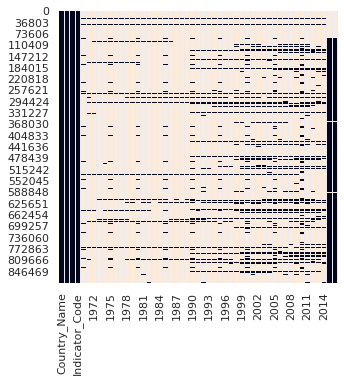

In [ ]:
sns.heatmap(main_df.isnull(), cbar=False)

In [ ]:
# grouped_main_df is a subset of main_df with country name that belongs to the category
grouped_main_df = main_df[main_df['Country_Name'].isin(category_list)]

# To gather any insights an indicator should values recorded for at least 3 years
# Dropping any row with more less less than 10 non NaNs and sorting rows according to # of Nans
grouped_main_df = grouped_main_df.dropna(thresh=10)
grouped_main_df['num_of_nans'] = grouped_main_df.isnull().sum(axis=1)

# Threshhold of 5 corresponds to the fact that values corresponding to all years is NaN 

grouped_main_df.sort_values('num_of_nans',inplace=True)
grouped_main_df.drop(columns = ['Region', 'Income_Group'])

#Creating df of individual countries
country_df = main_df.query('Country_Name not in @category_list').dropna(thresh=10)
country_df.drop(columns=['Indicator_Code','Country_Code'], inplace=True)

# startyear = 1970
# endyear = 2015

In [ ]:
append_df = grouped_main_df[[str(year) for year in list(range(1970,2015))]].interpolate(method = 'linear',axis=1,limit=3)
grouped_main_df = pd.concat([grouped_main_df[['Country_Name', 'Country_Code', 'Indicator_Name','num_of_nans']],append_df], axis = 1)

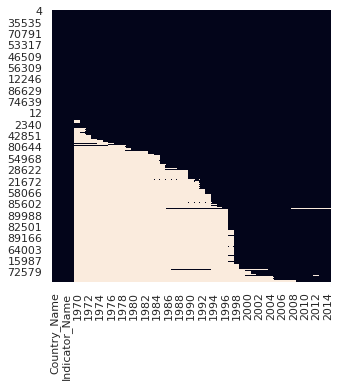

In [ ]:
sns.heatmap(grouped_main_df.isnull(), cbar = False)

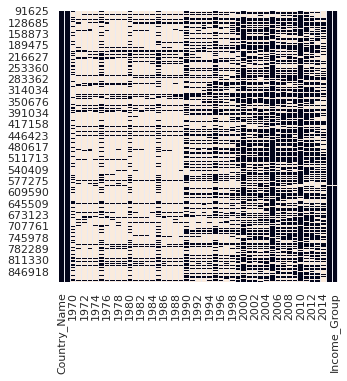

In [ ]:
sns.heatmap(country_df.isnull(), cbar=False)

### Identifying indicators that have majority of values as non NaNs

In [ ]:
ind_df = grouped_main_df.groupby('Indicator_Name', as_index=False)['Country_Name'].count().sort_values('Country_Name', ascending=False)
ind_df.drop(ind_df[ind_df['Country_Name']!=25].index, inplace=True)

In [ ]:
ind_list = ind_df['Indicator_Name'].tolist()

In [ ]:
cumulative_indicators = [ind for ind in ind_list if 'both sexes' in ind]

### List of important indicators for categories



### List of important indicators for countries
1. Barro-Lee : Provides the percentage of population in an age group with the amount of schooling
2. PISA: 

In [ ]:
barro_lee_indicators = country_df[country_df['Indicator_Name'].str.contains('Barro-Lee')]['Indicator_Name'].unique().tolist()

In [ ]:
pisa_indicators = country_df[country_df['Indicator_Name'].str.contains('PISA')]['Indicator_Name'].unique().tolist()

In [ ]:
pisa_maths_scores = [ind for ind in pisa_indicators if 'Distribution of Mathematics Scores' in ind]

##Writing Functions

In [ ]:
def CreateTimeSeriesdf(dataframe,indicator,grouping_list,startyear,endyear):

  years = [str(year) for year in list(range(startyear,endyear+1))]

  plot_df = dataframe.query('Indicator_Name == @indicator and Country_Name in @grouping_list')[['Country_Name']+years].T.reset_index()

  plot_df.columns = plot_df.iloc[0]
  plot_df = plot_df.iloc[1:].rename(columns = {'Country_Name':'year'})
  plot_df['year'] = pd.to_datetime(plot_df['year'])
  
  return plot_df


In [ ]:
def DetectOutliers(dataframe,indicators,country,startyear,endyear):
  years = [str(year) for year in list(range(startyear,endyear+1))]

  plot_df = dataframe.query('Indicator_Name in @indicators and Country_Name == @country')[['Indicator_Name']+years].T.reset_index()

  plot_df.columns = plot_df.iloc[0]
  plot_df = plot_df.iloc[1:].rename(columns = {'Indicator_Name':'year'})
  plot_df['year'] = pd.to_datetime(plot_df['year'])
  
  return plot_df

## Plots

###Visualizing the extent of Data Collection

2122 relevant indicators have been devised to understand the educational development of any country. However, data collection cannot be uniform throughout the globe because of access to resources and the willingness of different countries. 

Let's visualize what is the extent of data collection.

In [ ]:
country_df.Indicator_Name.unique().shape

(2122,)

In [ ]:
data_collection_df = country_df.groupby('Country_Name').count().drop(columns = ['Region','Income_Group']).reset_index()
data_collection_df['median_data_points'] = data_collection_df.drop(columns = ['Country_Name','Indicator_Name']).apply(lambda row: row.median(), axis=1)
data_collection_df = pd.merge(data_collection_df,country_df[['Country_Name','Region','Income_Group']],how='left',on = 'Country_Name')

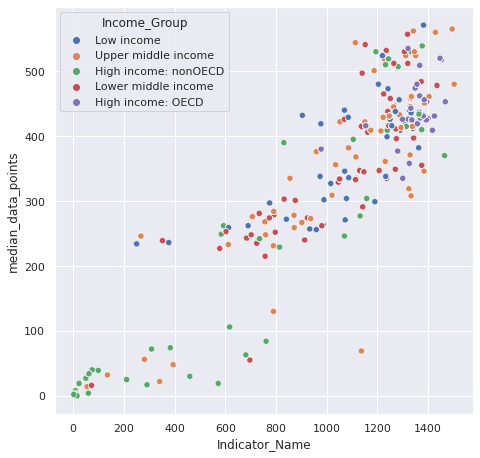

In [ ]:
sns.set(rc={'figure.figsize':(7.5,7.5)})

sns.scatterplot(data = data_collection_df, x = data_collection_df['Indicator_Name'],y = data_collection_df['median_data_points'], hue = 'Income_Group')

plt.show()

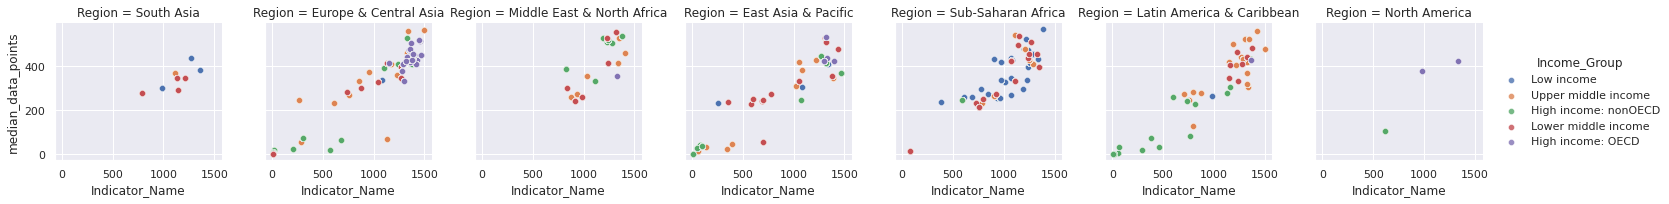

In [ ]:
sea = sns.FacetGrid(data_collection_df, col = 'Region',hue = 'Income_Group')
sea.map(sns.scatterplot,'Indicator_Name','median_data_points', alpha = .8)
  
# adding legend
sea.add_legend()
plt.show()

### GDP vs. Enrollment from 1995-2010

In [ ]:
country_df['Indicator_Name'].tolist()

['Adjusted net enrolment rate, lower secondary, both sexes (%)',
 'Adjusted net enrolment rate, lower secondary, female (%)',
 'Adjusted net enrolment rate, lower secondary, gender parity index (GPI)',
 'Adjusted net enrolment rate, lower secondary, male (%)',
 'All staff compensation as % of total expenditure in primary public institutions (%)',
 'All staff compensation as % of total expenditure in public institutions (%)',
 'All staff compensation as % of total expenditure in secondary public institutions (%)',
 'All staff compensation as % of total expenditure in tertiary public institutions (%)',
 'Barro-Lee: Average years of primary schooling, age 15+, female',
 'Barro-Lee: Average years of primary schooling, age 15+, total',
 'Barro-Lee: Average years of primary schooling, age 15-19, female',
 'Barro-Lee: Average years of primary schooling, age 15-19, total',
 'Barro-Lee: Average years of primary schooling, age 20-24, female',
 'Barro-Lee: Average years of primary schooling, age 

In [ ]:
CreateTimeSeriesdf(country_df,'Barro-Lee: Average years of secondary schooling, age 45-49, total',country_df['Country_Name'].unique().tolist(),2000,2010)

,year,Afghanistan,Albania,Algeria,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Barbados,Belgium,Belize,Benin,Bolivia,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burundi,Cambodia,Cameroon,Canada,Central African Republic,Chile,China,Colombia,"Congo, Dem. Rep.","Congo, Rep.",Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czech Republic,Denmark,Dominican Republic,Ecuador,"Egypt, Arab Rep.",El Salvador,...,Poland,Portugal,Qatar,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Sierra Leone,Singapore,Slovak Republic,Slovenia,South Africa,Spain,Sri Lanka,Sudan,Swaziland,Sweden,Switzerland,Syrian Arab Republic,Tajikistan,Tanzania,Thailand,Togo,Tonga,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,"Venezuela, RB",Vietnam,"Yemen, Rep.",Zambia,Zimbabwe
1,2000-01-01,0.53,3.1,1.1,2.01,6.11,5.19,5.12,2.49,1.14,3.22,4.15,2.19,0.64,2.07,1.75,2.37,3.4,1.94,0.2,0.57,1.01,4.61,0.52,3.36,1.19,2.22,0.39,2.32,1.85,0.83,2.57,4.1,3.86,3.64,5.04,1.37,1.69,1.5,1.1,...,3.27,2.15,2.46,3.08,6.26,0.2,1.98,0.58,2.12,0.55,3.74,2.94,3.34,1.62,3.61,2.5,0.54,0.88,5.26,4.45,1.08,7.15,0.26,0.55,1.08,3.37,1.87,1.59,1.37,0.41,6.12,2.81,3.35,5.74,2.57,1.41,1.28,0,1.09,0.93
2,2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2004-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2005-01-01,0.7,3.58,1.06,2.31,6.22,5.48,5.66,2.32,1.15,3.43,4.28,3,1.06,2.51,2.5,2.43,3.13,2.36,0.21,0.49,1.3,5.35,1,3.66,1.82,2.21,0.64,2.32,2.2,0.93,3.19,4.96,3.43,3.77,5.24,2.08,2.23,1.52,1.32,...,3.42,2.11,2.72,3.43,6.3,0.24,1.98,0.53,2.98,0.66,2.81,3.55,3.54,2.35,4.09,2.4,0.54,0.65,5.28,4.88,1.6,7.59,0.34,1.01,1.41,2.87,2.75,1.69,1.36,0.54,6.28,3.33,4.89,5.69,2.44,2,1.6,0.1,1.09,2.06
7,2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

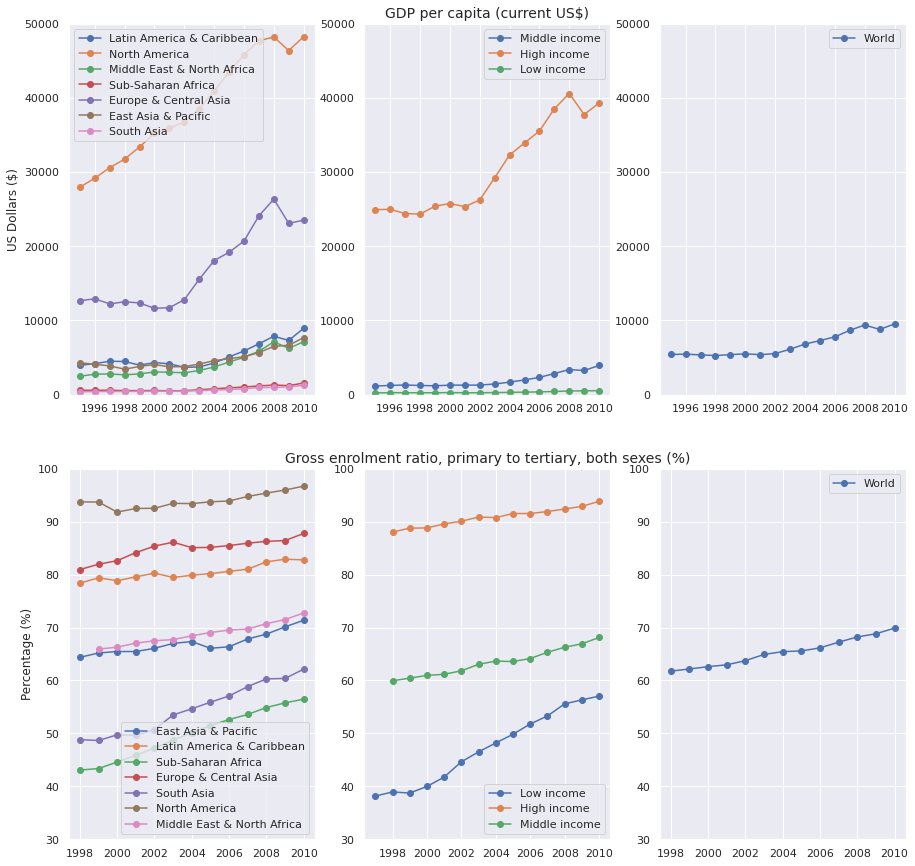

In [ ]:
gdp_indicator = 'GDP per capita (current US$)'
literacy_indicator =  'Gross enrolment ratio, primary to tertiary, both sexes (%)'

region = ['East Asia & Pacific','Europe & Central Asia','Latin America & Caribbean','Middle East & North Africa','South Asia',
           'Sub-Saharan Africa','North America']
income =  ['Low income','Middle income','High income']
world = ['World']

region_gdp_df = CreateTimeSeriesdf(grouped_main_df,gdp_indicator,region,1995,2010)
income_gdp_df = CreateTimeSeriesdf(grouped_main_df,gdp_indicator,income,1995,2010)
world_gdp_df = CreateTimeSeriesdf(grouped_main_df,gdp_indicator,world,1995,2010)

region_literacy_df = CreateTimeSeriesdf(grouped_main_df,literacy_indicator,region,1995,2010)
income_literacy_df = CreateTimeSeriesdf(grouped_main_df,literacy_indicator,income,1995,2010)
world_literacy_df = CreateTimeSeriesdf(grouped_main_df,literacy_indicator,world,1995,2010)

fig, ((ax01,ax02,ax03),(ax11,ax12,ax13)) = plt.subplots(nrows=2,ncols=3)

plt.rcParams['figure.figsize'] = (25,20)

# GDP per-capica plots 
ax01.plot_date(region_gdp_df['year'],region_gdp_df.loc[:,region_gdp_df.columns != 'year'], linestyle = 'solid')
ax01.set_ylim([0, 50000])
ax01.legend(region_gdp_df.columns.tolist()[1:])
ax01.set_ylabel('US Dollars ($)')


ax02.plot_date(income_gdp_df['year'],income_gdp_df.loc[:,income_gdp_df.columns != 'year'], linestyle = 'solid')
ax02.set_ylim([0, 50000])
ax02.legend(income_gdp_df.columns.tolist()[1:])

ax03.plot_date(world_gdp_df['year'],world_gdp_df.loc[:,world_gdp_df.columns != 'year'], linestyle = 'solid')
ax03.set_ylim([0, 50000])
ax03.legend(world_gdp_df.columns.tolist()[1:])

ax02.set_title(gdp_indicator,fontdict = {'fontsize':14})

ax11.plot_date(region_literacy_df['year'],region_literacy_df.loc[:,region_literacy_df.columns != 'year'], linestyle = 'solid')
ax11.set_ylim([30,100])
ax11.legend(region_literacy_df.columns.tolist()[1:])
ax11.set_ylabel('Percentage (%)')

ax12.plot_date(income_literacy_df['year'],income_literacy_df.loc[:,income_literacy_df.columns != 'year'], linestyle = 'solid')
ax12.set_ylim([30,100])
ax12.legend(income_literacy_df.columns.tolist()[1:])

ax13.plot_date(world_literacy_df['year'],world_literacy_df.loc[:,world_literacy_df.columns != 'year'], linestyle = 'solid')
ax13.set_ylim([30,100])
ax13.legend(world_literacy_df.columns.tolist()[1:])

ax12.set_title(literacy_indicator,fontdict = {'fontsize':14})

plt.show()


### Plotting more than one indicator for a specific year in one plot

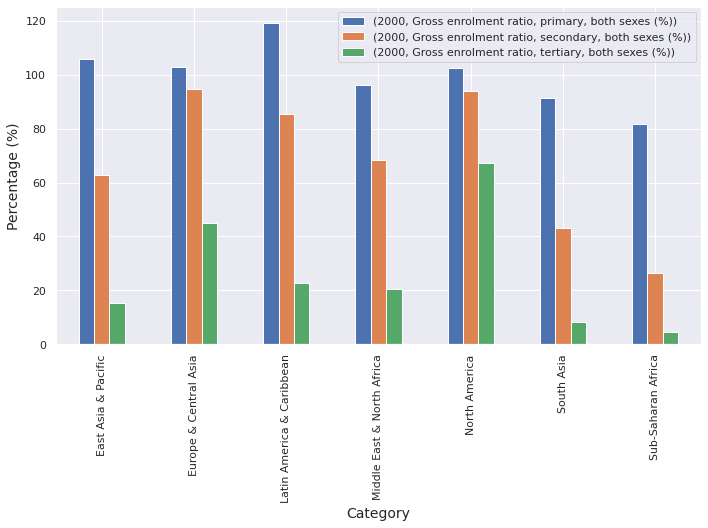

In [ ]:
data = grouped_main_df
year = 2000

indicators = ['Gross enrolment ratio, primary, both sexes (%)',
 'Gross enrolment ratio, tertiary, both sexes (%)',
 'Gross enrolment ratio, secondary, both sexes (%)']

grouped_df = data[data['Indicator_Name'].isin(indicators)]
grouped_df = grouped_df[grouped_df['Country_Name'].isin(region)]
grouped_df.dropna(axis=1,thresh=10,inplace=True)

plt.rcParams['figure.figsize'] = (10,7.5)

pivot_df = pd.pivot_table(grouped_df, index='Country_Name', columns='Indicator_Name', values=[str(year)], dropna=True)

pivot_df.plot(kind='bar', legend=True)
plt.legend()
plt.xlabel('Category',fontdict={'fontsize':14})
plt.ylabel('Percentage (%)',fontdict={'fontsize':14})
plt.tight_layout()
plt.show()

### Correlations

In [ ]:
correlation_candidates = random.sample(country_df['Indicator_Name'].unique().tolist(),10)

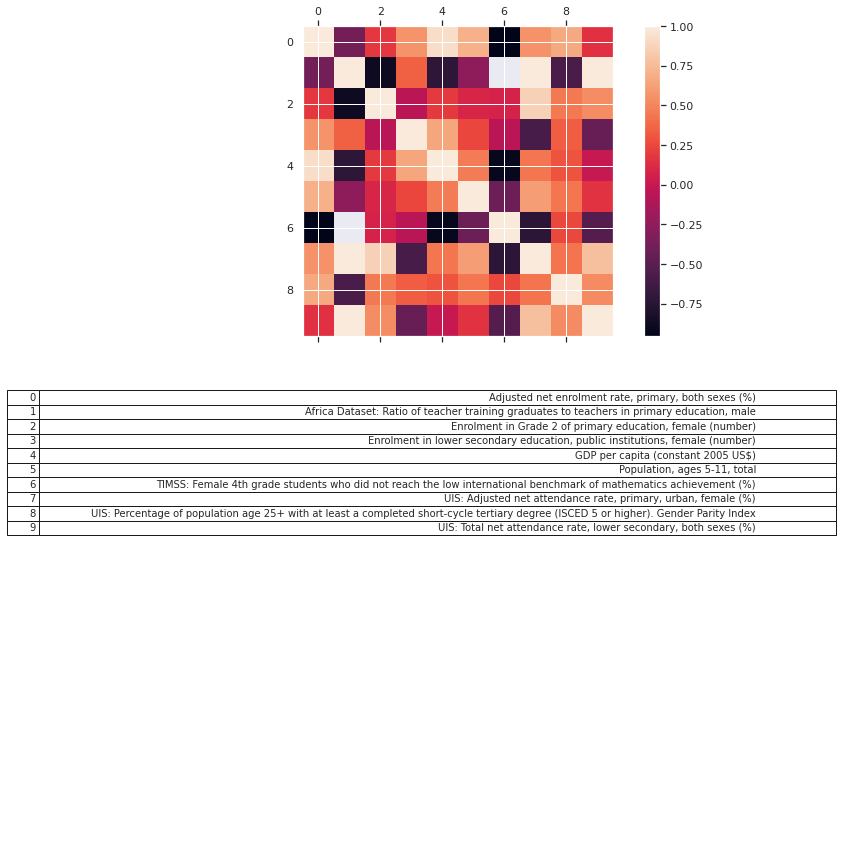

In [ ]:
corr_df = pd.pivot_table(country_df.query('Indicator_Name in @correlation_candidates'), columns='Indicator_Name').corr()

cell_val = []
for i in range(corr_df.shape[0]):
  cell_val.append([i,corr_df.columns[i]])

fig, (ax,tabax) = plt.subplots(nrows = 2)
plt.subplots_adjust(bottom=-0.1)
plt.rcParams['figure.figsize'] = [5,5]

# Correlation heatmap 
im = ax.matshow(corr_df)
plt.gcf().set_size_inches(12, 12)
cb = plt.colorbar(im ,ax = ax)

# Indicator Name and Index table 
tabax.axis('off')
the_table = tabax.table(cellText=cell_val, loc='top', colWidths=[0.05,1.25], cellLoc='right', rowLoc = 'center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1,1.5)


plt.tight_layout()
plt.show()

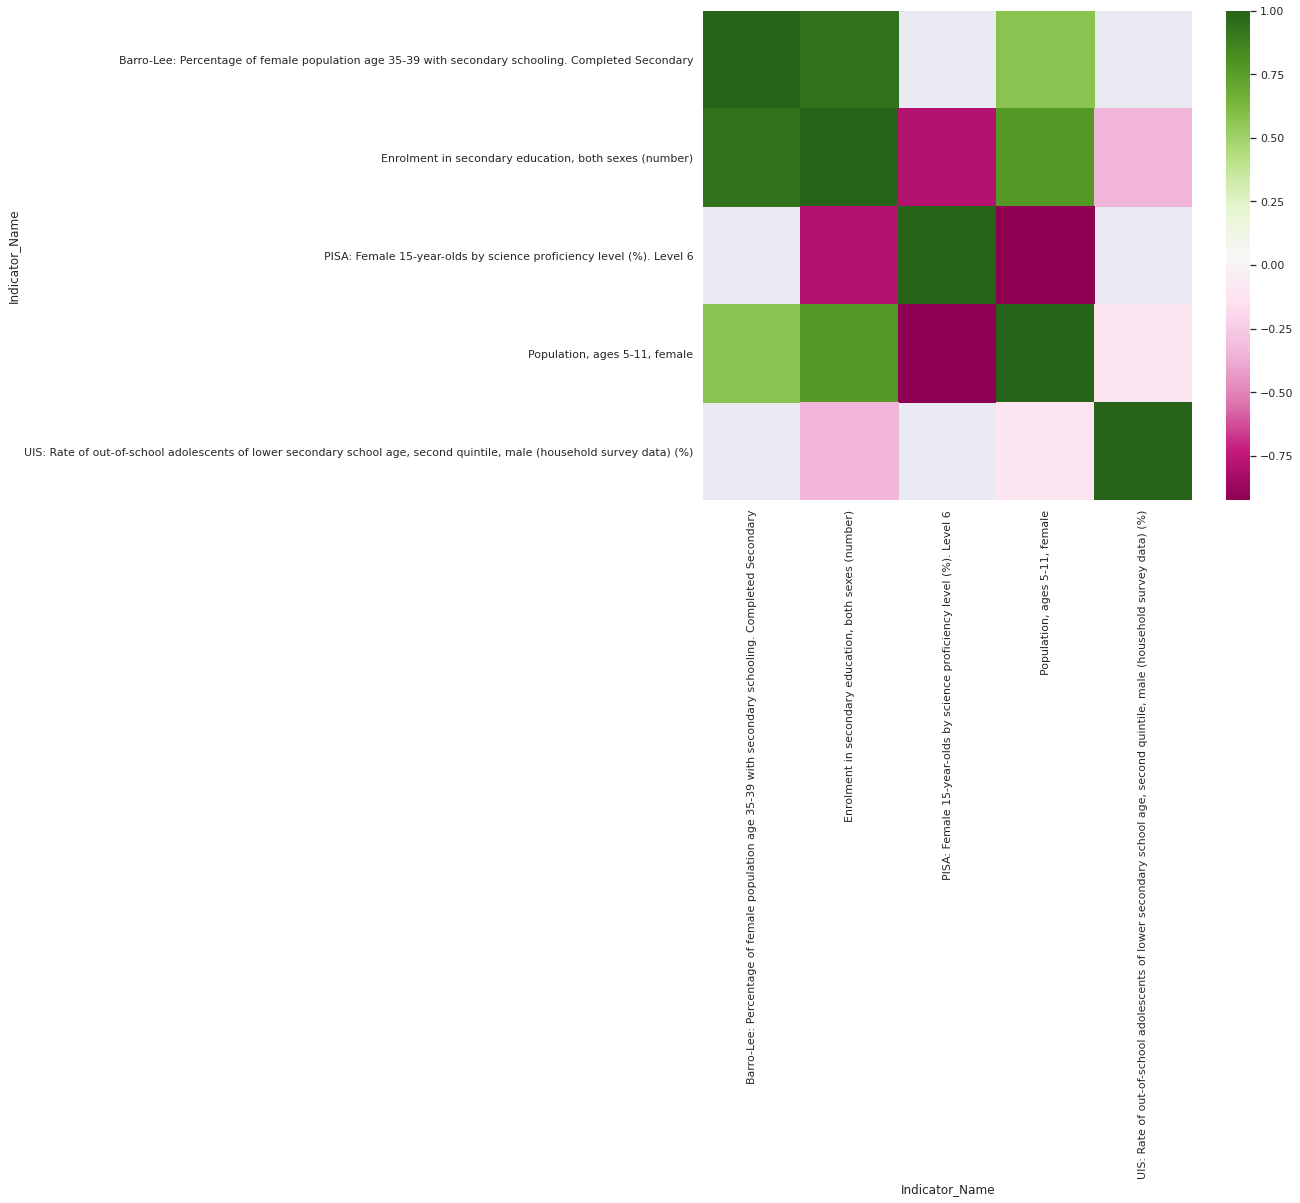

In [ ]:
correlation_candidates = random.sample(country_df['Indicator_Name'].unique().tolist(),5)
corr_df = pd.pivot_table(country_df.query('Indicator_Name in @correlation_candidates'), columns='Indicator_Name').corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_df, vmax=1, square=True, cmap="PiYG")

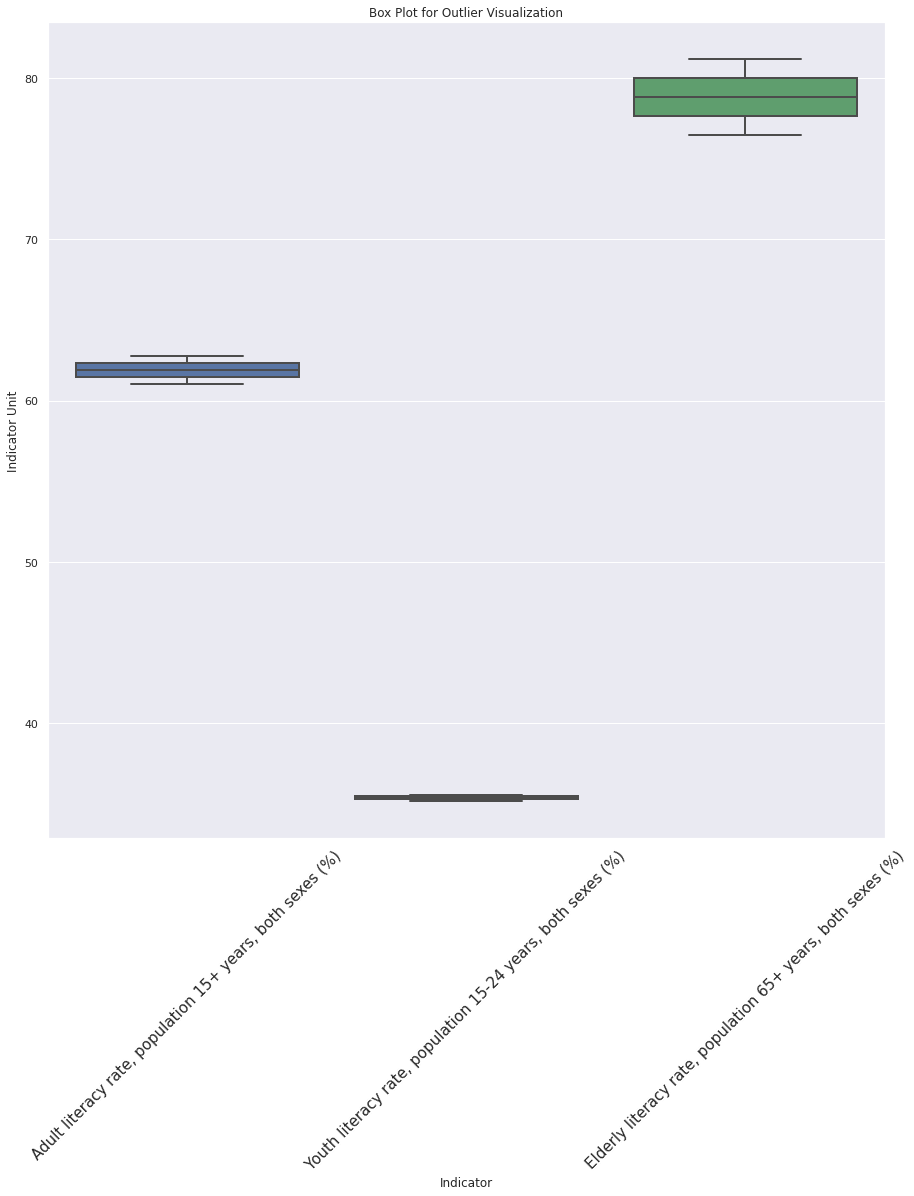

In [ ]:
focused_indicators=  ['Adult literacy rate, population 15+ years, both sexes (%)','Youth literacy rate, population 15-24 years, both sexes (%)'
                ,'Elderly literacy rate, population 65+ years, both sexes (%)']
box_plot_df = DetectOutliers(country_df,focused_indicators,'India',1995,2010)

plt.rcParams['figure.figsize'] = (15,15) 
sns_plot = sns.boxplot(data = box_plot_df, linewidth=2)

sns_plot.set_xticks(list(range(0,len(focused_indicators))))
sns_plot.set_xticklabels(focused_indicators, rotation=45, size=15)

# sns_plot.figure.savefig("output.png")
# files.download("abc.png") 

plt.xlabel('Indicator', size = 12)
plt.ylabel('Indicator Unit',size = 12)
plt.title('Box Plot for Outlier Visualization',size = 12)
plt.show()